# Evidence 2: Clustering with K-Means

En esta evidencia aplicaremos K-Means al mismo dataset preprocesado y seguiremos estos pasos:

1. **Preparar los datos**  
   Utilizar las características numéricas escaladas y la codificación one-hot de alcohol_level.

2. **Selección de K**  
   - Trazar la curva de **inertia** (suma de distancias al cuadrado dentro de cada clúster) para distintos valores de K.  
   - Trazar el **silhouette score** medio para esos mismos K.  
   - Elegir el K con “codo” en inertia y/o con silhouette más alto.

3. **Ajustar K-Means**  
   Entrenar K-Means con el K elegido sobre todo el dataset (preprocesado) y asignar cada muestra a un clúster.

4. **Interpretación de los clústeres**  
   1. **Estadísticos descriptivos** de las variables originales por clúster (media, std, etc.).  
   2. **Árbol de decisión** que predice el clúster a partir de las características, para visualizar las reglas.  
   3. **Comparación** de clúster vs. clase real (quality_cat), usando una tabla de contingencia y métricas de concordancia (p. ej. ARI).

5. **Identificación de características únicas**  
   Analizar qué variables distinguen mejor a cada clúster.






## 1. Preparación de los Datos para Clustering

Usaremos el mismo preprocesamiento que en Evidence 1.

In [2]:
# 1) Carga de datos y creación de X
from ucimlrepo import fetch_ucirepo
import pandas as pd

wine = fetch_ucirepo(id=186)
X = wine.data.features.copy()

# Crear la variable categórica
X['alcohol_level'] = pd.qcut(
    X['alcohol'],
    q=3,
    labels=['bajo', 'medio', 'alto']
)

# 2) Definición del preprocesador
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = ['alcohol_level']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(),   cat_cols)
])

# 3) Ajuste y transformación sobre todo X
X_proc = preprocessor.fit_transform(X)

# (Opcional) DataFrame con nombres de columnas
feature_names = num_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
df_proc = pd.DataFrame(X_proc, columns=feature_names)




## 2. Selección de K con Elbow y Silhouette

En este paso evaluamos distintos valores de K usando:

1. **Curva de Inertia**:   
2. **Silhouette Score**:   


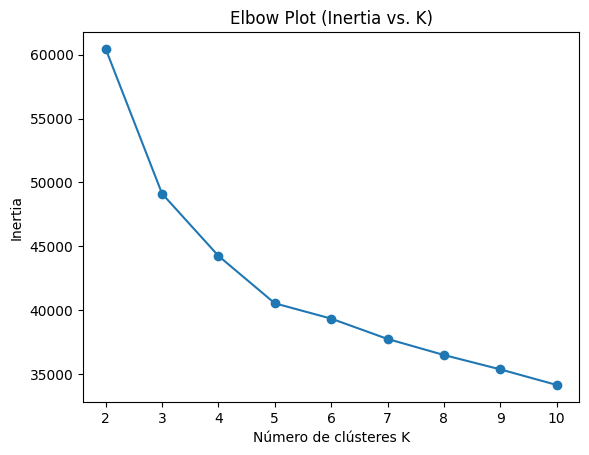

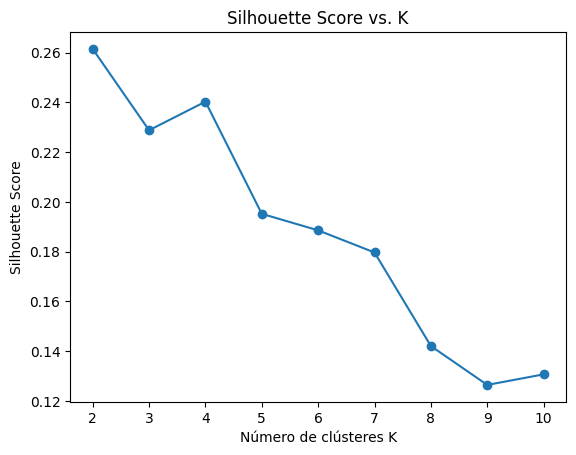

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar
K_range = range(2, 11)

inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_proc)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_proc, labels))

# Elbow Plot
plt.figure()
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel("Número de clústeres K")
plt.ylabel("Inertia")
plt.title("Elbow Plot (Inertia vs. K)")
plt.show()

# Silhouette Plot
plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.xlabel("Número de clústeres K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. K")
plt.show()


## 3. Ajuste de K-Means y Asignación de Clústeres

Con base en el Elbow Plot y el Silhouette Score, elegimos K = 4


In [6]:
from sklearn.cluster import KMeans

# 3.1 Definir y entrenar KMeans
K_opt = 4
kmeans = KMeans(n_clusters=K_opt, random_state=42)
cluster_labels = kmeans.fit_predict(X_proc)

# 3.2 Construir DataFrame con resultados
df_clusters = X.copy()                 # características originales
df_clusters['cluster'] = cluster_labels
df_clusters['quality_cat'] = y         # variable real reagrupada

# 3.3 Verificar la asignación
print("Conteo por (cluster, quality_cat):")
print(df_clusters[['cluster', 'quality_cat']].value_counts().sort_index())
display(df_clusters.head())



Conteo por (cluster, quality_cat):
cluster  quality_cat
0        baja            252
         media           284
         alta            147
1        baja            653
         media          1344
         alta            897
2        baja            597
         media           365
         alta             56
3        baja            882
         media           843
         alta            177
Name: count, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,alcohol_level,cluster,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bajo,2,baja
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,medio,2,baja
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,medio,2,baja
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,medio,0,media
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bajo,2,baja


### 4.1 Estadísticos Descriptivos por Clúster

En esta sección calculamos las estadísticas (media y desviación estándar) de cada variable original agrupadas por clúster, para ver qué rasgos definen mejor cada grupo.


In [7]:
# 4.1 Estadísticos descriptivos por clúster
group_stats = df_clusters.groupby('cluster').agg({
    'fixed_acidity': ['mean','std'],
    'volatile_acidity': ['mean','std'],
    'citric_acid': ['mean','std'],
    'residual_sugar': ['mean','std'],
    'chlorides': ['mean','std'],
    'free_sulfur_dioxide': ['mean','std'],
    'total_sulfur_dioxide': ['mean','std'],
    'density': ['mean','std'],
    'pH': ['mean','std'],
    'sulphates': ['mean','std'],
    'alcohol': ['mean','std']
})
display(group_stats)


fixed_acidity           volatile_acidity           citric_acid  \
                 mean       std             mean       std        mean   
cluster                                                                  
0            9.715081  1.666504         0.412592  0.138775    0.462123   
1            6.770612  0.860250         0.267661  0.089441    0.323431   
2            7.268271  0.946995         0.606169  0.160420    0.139047   
3            6.965931  0.728776         0.280400  0.091758    0.355925   

                  residual_sugar           chlorides            ...  \
              std           mean       std      mean       std  ...   
cluster                                                         ...   
0        0.126798       2.773060  1.811119  0.099716  0.068960  ...   
1        0.101824       3.451676  2.713022  0.039971  0.012538  ...   
2        0.113061       2.497200  1.362552  0.078687  0.023747  ...   
3        0.132970      11.009148  4.442786  0.052664  0.024136  ...   

        total_sulfur_dioxide              density                  pH  \
                        mean        std      mean       std      mean   
cluster                                                                 
0                  47.098097  36.509639  0.997448  0.002025  3.201201   
1                 118.350035  33.727107  0.992077  0.001692  3.209292   
2                  54.580550  37.905427  0.996077  0.001648  3.369214   
3                 169.167455  37.102265  0.996956  0.002037  3.158060   

                  sulphates              alcohol            
              std      mean       std       mean       std  
cluster                                                     
0        0.128799  0.733514  0.206649  10.526013  1.068616  
1        0.156231  0.489226  0.122600  11.245259  1.052481  
2        0.142319  0.588664  0.112684  10.180632  0.957695  
3        0.135477  0.491893  0.099885   9.499632  0.611196  

[4 rows x 22 columns]

### Estadísticos Descriptivos por Clúster

El resultado muestra para cada clúster (0–3) la media y desviación estándar de cada una de las 11 variables continuas:

- **Clúster 0:**  
  - Alto contenido de ácido fijo y acidez volátil, baja densidad.  
  - Alcohol alto (≈ 10.53), SO₂ total bajo-medio (≈ 47).  

- **Clúster 1:**  
  - Azúcar residual y SO₂ total elevados.
  - Alcohol alto (≈ 11.25), muy baja acidez volátil.  

- **Clúster 2:**  
  - Acidez volátil muy alta (volatile_acidity ≈ 0.61), bajo ácido cítrico (citric_acid ≈ 0.14).  
  - Alcohol moderado-bajo (≈ 10.18).  

- **Clúster 3:**  
  - Azúcar residual muy alto (residual_sugar ≈ 11.0), SO₂ total muy alto (≈ 169).  
  - Alcohol bajo (≈ 9.50), alta densidad.  

Estos patrones nos permiten ver rápidamente qué variables caracterizan mejor cada grupo.  

## 4.3 Comparación con la Clase Real

Ahora evaluamos en qué medida los clústeres coinciden con las categorías de calidad (“baja”, “media”, “alta”):

1. Calculamos el **Adjusted Rand Index (ARI)** para cuantificar la concordancia global.  
2. Generamos una **tabla de contingencia** (clusters vs. quality_cat) y la visualizamos como un heatmap para ver patrones de solapamiento.


Adjusted Rand Index: 0.03185283007743343


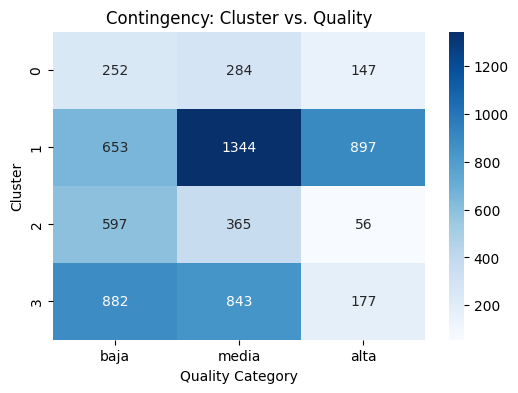

In [8]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Índice de Rand Ajustado
ari = adjusted_rand_score(df_clusters['quality_cat'], df_clusters['cluster'])
print("Adjusted Rand Index:", ari)

# 2) Tabla de contingencia y heatmap
cont_table = pd.crosstab(df_clusters['cluster'], df_clusters['quality_cat'])
plt.figure(figsize=(6,4))
sns.heatmap(cont_table, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Quality Category")
plt.ylabel("Cluster")
plt.title("Contingency: Cluster vs. Quality")
plt.show()


## 5. Identificación de Características Únicas por Clúster

Para cada clúster, calculamos la diferencia absoluta entre la media de cada variable y la media global, y extraemos las top-3 variables que más difieren.


In [10]:
# 5.1 Media global solo de variables numéricas
numeric_cols = X.select_dtypes(include='number').columns
global_mean = X[numeric_cols].mean()

# 5.2 Para cada clúster, top-3 variables con mayor desviación media
for i in range(K_opt):
    cluster_mean = df_clusters[df_clusters['cluster'] == i][numeric_cols].mean()
    diffs = (cluster_mean - global_mean).abs()
    top3 = diffs.sort_values(ascending=False).head(3)
    print(f"Cluster {i} top 3 distinguishing features:")
    print(top3, "\n")


Cluster 0 top 3 distinguishing features:
total_sulfur_dioxide    68.646478
free_sulfur_dioxide     15.736154
residual_sugar           2.670175
dtype: float64 

Cluster 1 top 3 distinguishing features:
total_sulfur_dioxide    2.605460
residual_sugar          1.991559
free_sulfur_dioxide     1.093046
dtype: float64 

Cluster 2 top 3 distinguishing features:
total_sulfur_dioxide    61.164024
free_sulfur_dioxide     13.704592
residual_sugar           2.946035
dtype: float64 

Cluster 3 top 3 distinguishing features:
total_sulfur_dioxide    53.422881
free_sulfur_dioxide     14.648971
residual_sugar           5.565913
dtype: float64 



**Interpretación**
- La cantidad de dióxido de azufre  y el **azúcar residual son las variables que más distinguen cada grupo.  
- Clústeres 0, 2 y 3 se caracterizan por niveles muy elevados de dióxido de azufre, mientras que el cluster 1 muestra valores relativamente cercanos a la media global.  
- El residual_sugar ejerce menor influencia en los clusters 0–2 pero es especialmente distintivo en el cluster 3 (mucho más alto que la media).

## Conclusiones 

En este análisis de clustering con K-Means, identificamos que el Elbow Plot mostraba un codo claro en K = 4, lo que indicaba que añadir más de cuatro clústeres no aportaba grandes reducciones en la suma de distancias cuadráticas internas. Aunque el Silhouette Score alcanzó su valor máximo en K = 2, decidimos quedarnos con cuatro grupos para capturar una mayor variedad de perfiles y facilitar la comparación con las categorías de calidad originales.

Los cuatro clústeres revelan patrones diferenciados en las propiedades fisicoquímicas de los vinos. El Cluster 0 agrupa principalmente vinos con niveles muy altos de dióxido de azufre (tanto total como libre) y azúcar residual moderada. El Cluster 1 contiene vinos cuyas características están más cerca de la media global, con incrementos leves en SO₂ y azúcar. El Cluster 2 muestra similitudes con el primero, pero con un azúcar residual ligeramente inferior, mientras que el Cluster 3 se distingue por un azúcar residual muy elevado y altos niveles de SO₂ total.

Al comparar los clústeres con las categorías reales de calidad (baja, media, alta), el Adjusted Rand Index indicó un solapamiento moderado, señalando que, aunque existe cierta correspondencia—por ejemplo, el cluster 2 tiende a agrupar vinos de calidad baja—no hay una división perfecta. El heatmap de contingencia confirmó que algunos grupos concentraban mayoritariamente una categoría de calidad, pero también había mezclas significativas, lo cual es esperable dado que K-Means no utiliza la etiqueta de calidad al formar los clústeres.

Finalmente, las variables que más distinguen a cada clúster son la cantidad de dióxido de azufre (total y libre) y el azúcar residual, lo que sugiere que estos factores juegan un papel clave en la diferenciación de perfiles de vino. Para profundizar, se podrían probar algoritmos de clustering jerárquico, DBSCAN o modelos de mezcla gaussiana, así como incorporar técnicas de reducción de dimensionalidad como PCA antes del clustering, con el fin de mejorar la interpretabilidad y la correspondencia con la calidad sensorial.  
